In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scripts.interactions
import matplotlib.pylab as plt
import seaborn as sbn
# project_file = '/home/matej/prace/ferda/projects/camera1_10-15/10-15.fproj'
project_file = '/home/matej/prace/ferda/projects/Cam1_clip/Cam1.fproj'
detector_model_dir = '/home/matej/prace/ferda/experiments/180222_2253_mobilenet_two_100'
sbn.set_style('darkgrid')
from utils.video_manager import get_auto_video_manager
import pandas as pd
from scripts.CNN.interactions_results import save_prediction_img
from os.path import join
import os
import imageio
import tempfile
from tqdm import tqdm_notebook as tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
it = scripts.interactions.Interactions()
it._load_project(project_file)
# it._init_regions()
p = it._project
gm = p.gm
rm = p.rm
im = p.img_manager
vm = get_auto_video_manager(p)
cm = p.chm

Initializing db at /home/matej/prace/ferda/projects/Cam1_clip/rm.sqlite3 
saving chm


In [4]:
from utils.gt.gt import GT

gt = GT()
gt.load('data/GT/Cam1_.pkl')
gt.set_offset()
gt._GT__positions[1000]

GT was sucessfully loaded from  data/GT/Cam1_.pkl


[(418.3138351983723, 341.6281790437436, 1),
 (730.5194384449244, 545.2861771058315, 1),
 (649.1040688575899, 247.6564945226917, 1),
 (565.248831775701, 545.7301401869158, 1),
 (497.08813559322033, 496.67118644067796, 1),
 (561.7111959287532, 234.1704834605598, 1)]

[(492.82358870967744, 97.16431451612904), (196.25075075075074, 117.23123123123123), (524.659217877095, 158.29189944134077), (330.973623853211, 88.5091743119266), (348.15895953757223, 182.34682080924856), (471.4572953736655, 182.39679715302492)]


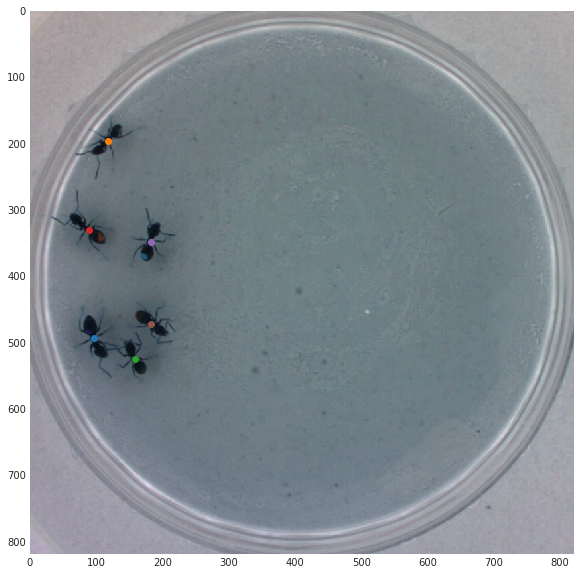

In [5]:
frame = 10
plt.figure(figsize=(10,10))
plt.grid(None)
plt.imshow(im.get_whole_img(frame))
# plt.imshow(vm.get_frame(frame))
for y, x in gt.get_positions(frame):
    plt.plot(x, y, 'o')
    
print gt.get_clear_positions(frame)

In [6]:
# extract multi tracklets
multi = [t for t in cm.chunk_gen() if t.is_multi()]
len(multi)

353

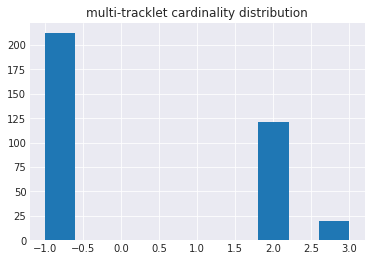

In [7]:
_ = plt.hist([tracklet.get_cardinality(gm) for tracklet in multi])
_ = plt.title('multi-tracklet cardinality distribution')

In [8]:
tracklets2 = [t for t in multi if t.get_cardinality(gm) == 2]
len(tracklets2)

121

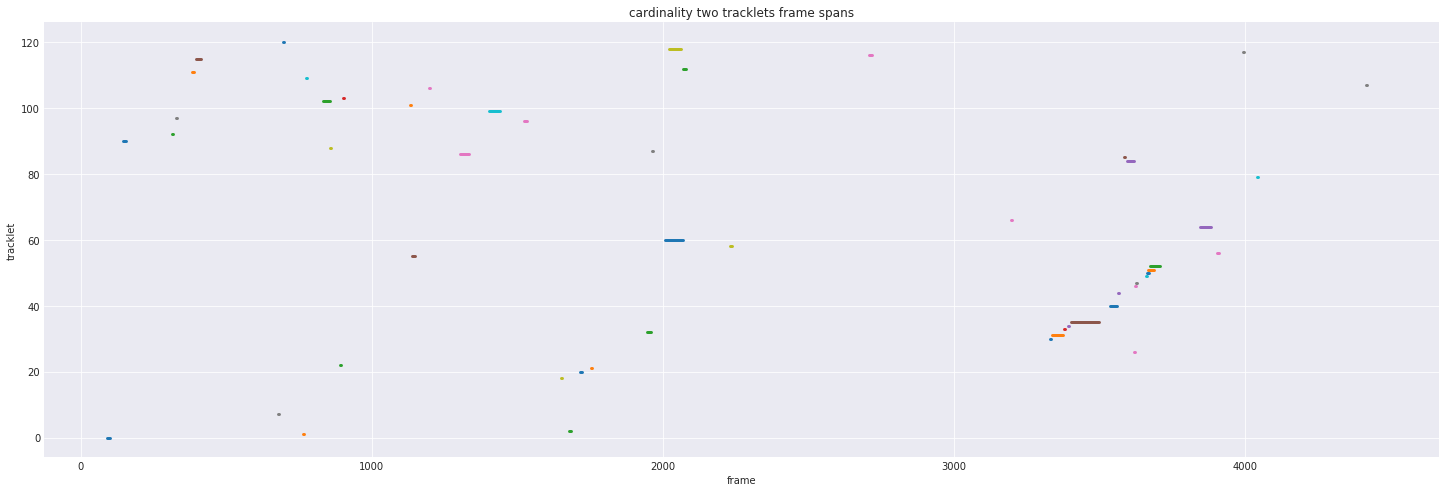

In [9]:
plt.figure(figsize=(25, 8))
for i, t in enumerate(tracklets2):
    plt.plot([t.start_frame(gm), t.end_frame(gm)], [i, i], linewidth=3)
plt.title('cardinality two tracklets frame spans')   
plt.xlabel('frame')
_ = plt.ylabel('tracklet')

In [10]:
# sort tracklets by length 
tracklets2.sort(lambda x,y: cmp(len(x), len(y)), reverse=True)

In [11]:
# t = tracklets2[0]
# plt.figure(figsize=(10,10))
# plt.grid(None)
# plt.imshow(im.get_whole_img(t.start_frame(gm)))
# # plt.imshow(vm.get_frame(frame))
# t.v_gen()
# plt.plot()
# for y, x in gt.get_positions(frame):
#     plt.plot(x, y, 'o')
    
# print gt.get_clear_positions(frame)  

In [12]:
t.print_info(gm)

TRACKLET --- id: 4093 length: 5
	starts at: 694 ends at: 698


In [13]:
# statistics: multi as entering, exiting tracklets
t = tracklets2[5]
# list(t.r_gen(gm, rm))[0, -1]:
multi_stats = []
for t in tracklets2:
    multi_stats.append((
        np.array([tracklet.is_multi() for tracklet in t.entering_tracklets(gm)]).mean(),  
        len(t.entering_tracklets(gm)),
        np.array([tracklet.is_multi() for tracklet in t.exiting_tracklets(gm)]).mean(),
        len(t.exiting_tracklets(gm)),
        ))
multi_stats = pd.DataFrame(multi_stats, 
             columns=['entering is multi', 'n entering', 'exiting is multi', 'n exiting'])

multi_stats.style.format({
    'entering is multi': '{:,.0%}'.format,
    'exiting is multi': '{:,.0%}'.format,
})

,entering is multi,n entering,exiting is multi,n exiting
0,0%,2,100%,1
1,0%,2,100%,2
2,0%,2,0%,2
3,0%,2,50%,2
4,0%,2,0%,2
5,0%,2,0%,2
6,0%,2,0%,2
7,0%,2,50%,2
8,100%,1,0%,2
9,0%,2,0%,2


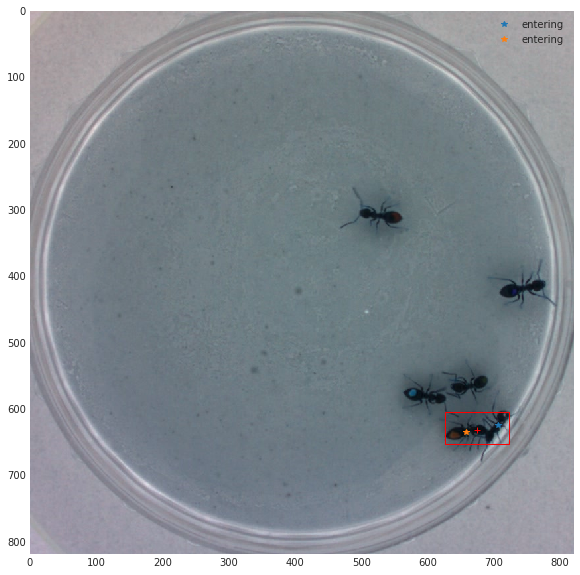

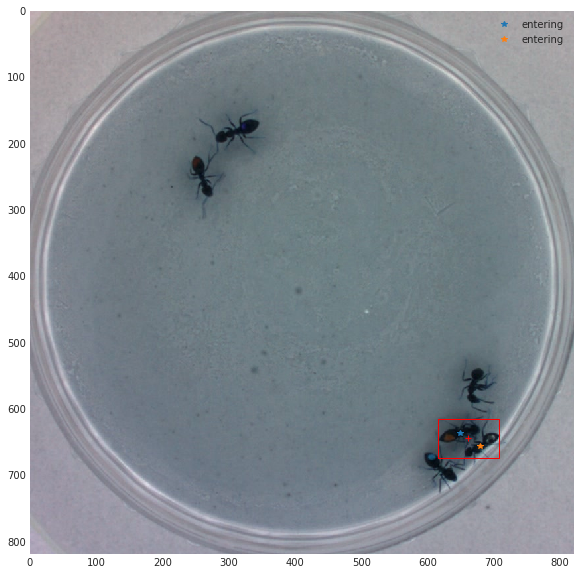

In [14]:
# plot situation directly before and after tracklet life span
t = tracklets2[5]
regions = list(t.r_gen(gm, rm))
for i in [0, -1]:
    r = regions[i]
    fig, ax = plt.subplots(1, figsize=(10, 10))
    plt.grid(False)
    img = im.get_whole_img(r.frame())
#     mask = np.zeros_like(img, dtype=np.bool)
#     mask = r.draw_mask(mask)
#     img[mask == False] = 255
    plt.imshow(img)
    roi = r.roi()
    ax.add_patch(plt.Rectangle((roi.x(), roi.y()), roi.width(), roi.height(), linewidth=1, edgecolor='r', facecolor='none'))
    plt.plot(r.centroid()[1], r.centroid()[0], 'r+')
      
    if i == 0:
        for tracklet in t.entering_tracklets(gm):
            yx = gm.region(tracklet.end_node()).centroid()
            plt.plot(yx[1], yx[0], '*', label='entering' if not tracklet.is_multi() else 'entering (multi)')

    if i == -1:
        for tracklet in t.exiting_tracklets(gm):
            yx = gm.region(tracklet.start_node()).centroid()
            plt.plot(yx[1], yx[0], '*', label='entering' if not tracklet.is_multi() else 'entering (multi)')
    
    plt.legend()

# Interaction Detector

In [15]:
from scripts.CNN.interactions import InteractionDetector
# detector = InteractionDetector('/home/matej/prace/ferda/experiments/171222_0126_batch_36k_random/0.928571428571')
detector = InteractionDetector(detector_model_dir)

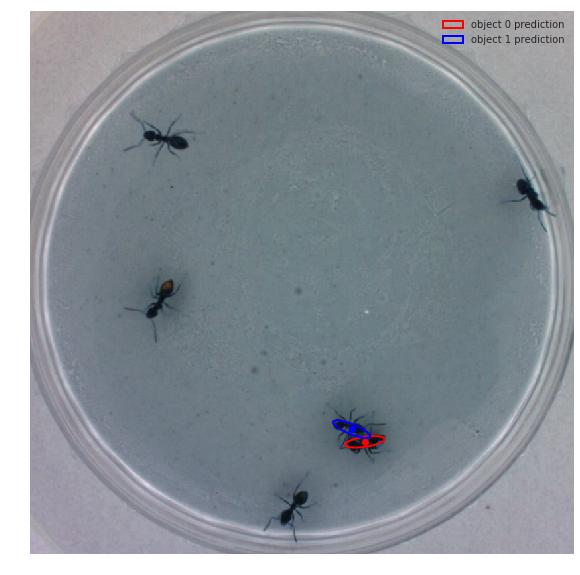

In [16]:
# detect objects in random interaction
t = np.random.choice(tracklets2)
regions = list(t.r_gen(gm, rm))
r = np.random.choice(regions)
img = im.get_whole_img(r.frame())

predictions = detector.detect(img, r.centroid()[::-1])
for i in range(2):
    predictions['{}_major'.format(i)] = 60
    predictions['{}_minor'.format(i)] = 15
plt.figure(figsize=(10, 10))
detector.draw_detections(img, predictions)

In [17]:
 def get_predictions(tracklet):
    images = []
    predictions = []
    for r in tqdm(list(tracklet.r_gen(gm, rm)), desc='interaction detections', leave=False):
        img = im.get_whole_img(r.frame())
        pred = detector.detect(img, r.centroid()[::-1])
        for obj_i in range(2):
            pred['{}_major'.format(obj_i)] = 60
            pred['{}_minor'.format(obj_i)] = 15        
        images.append(img)
        predictions.append(pred)
    return predictions, images    

In [18]:
# detect objects in all interactions (takes few minutes on CPU and Cam1.fproj)
tracklets2_detections = []
for t in tqdm(tracklets2):
    detections, _ = get_predictions(t)
    tracklets2_detections.append(detections)

HBox(children=(IntProgress(value=0, max=121), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=96), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=63), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=42), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=40), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=39), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=38), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=35), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=29), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=25), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=24), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=24), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=21), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=15), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=15), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=11), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=11), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=11), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=10), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=9), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=9), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=9), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=9), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=8), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=7), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=6), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=5), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=4), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=2), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=1), HTML(value=u'')))

In [26]:
pd.DataFrame(tracklets2_detections[20], columns=detector.predictions.columns())

,0_x,0_y,0_angle_deg,1_x,1_y,1_angle_deg
0,553.884491,698.342865,48.105595,519.927086,719.712746,-30.001335
1,552.796661,698.099731,46.818966,519.873466,719.442657,-29.238745
2,552.820038,698.457848,44.155945,520.515343,717.912277,-29.982412
3,552.792419,698.958397,44.793247,520.831413,718.420227,-28.184057
4,553.190994,698.576057,45.624447,521.096352,718.198608,-27.689835
5,553.792534,698.482796,44.320518,521.620422,718.470222,-26.876556
6,553.987900,698.221512,44.880787,521.809792,718.317902,-26.320599
7,553.884590,697.805435,45.065861,521.304741,718.529579,-24.457634
8,553.518471,698.219208,44.859528,520.926918,718.790970,-23.219902


/home/matej/.virtualenvs/ferda/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


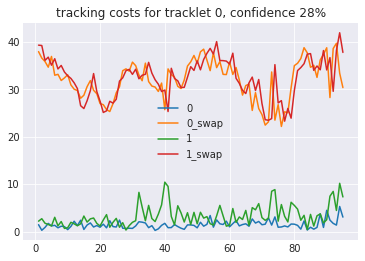

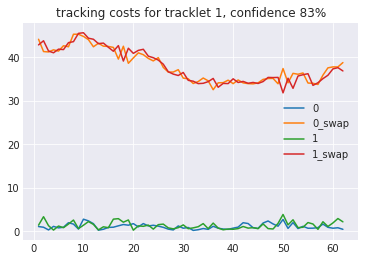

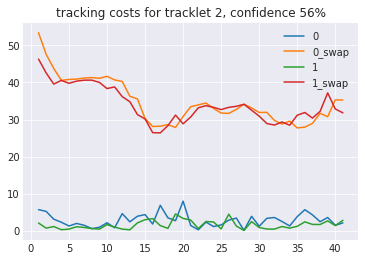

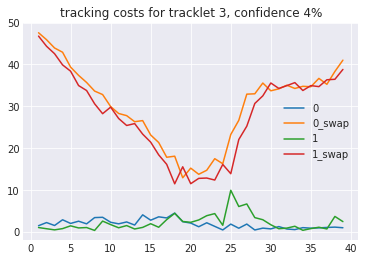

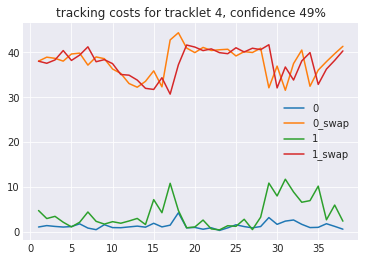

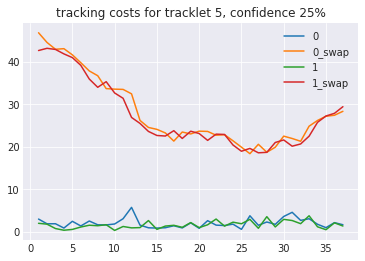

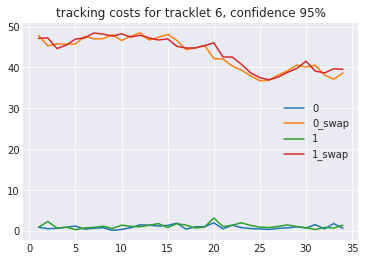

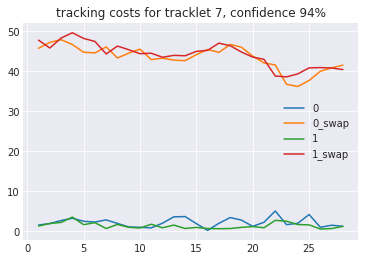

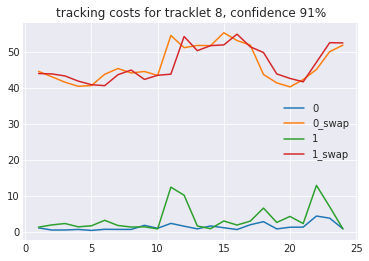

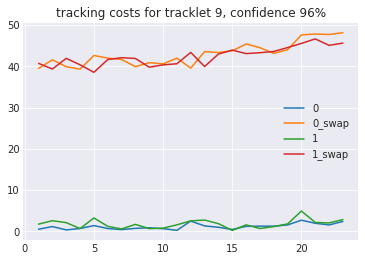

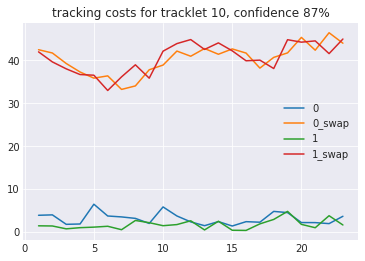

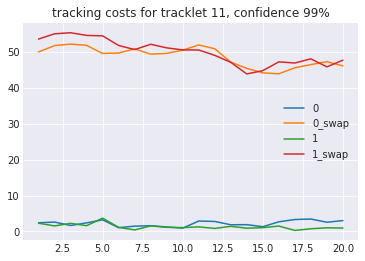

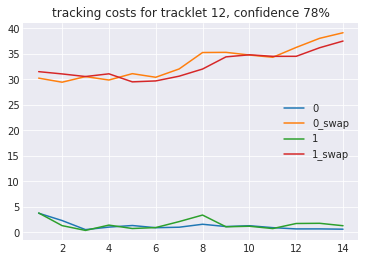

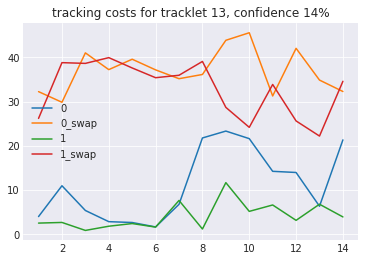

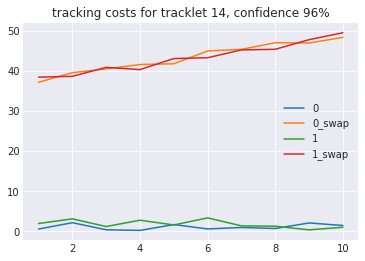

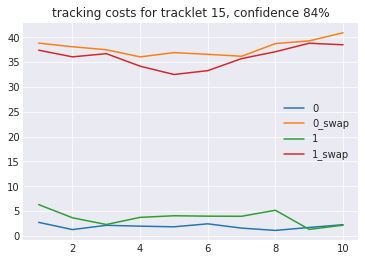

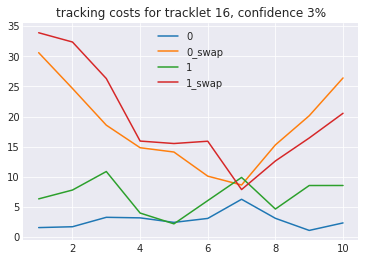

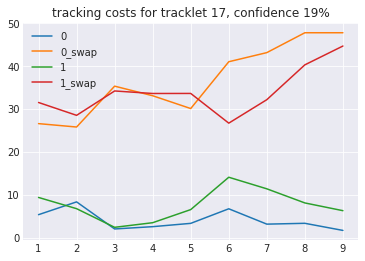

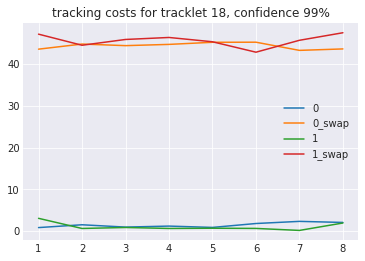

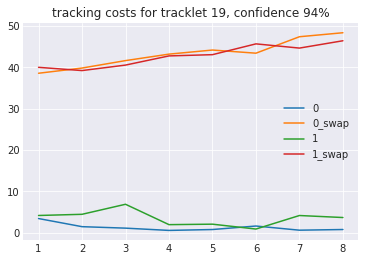

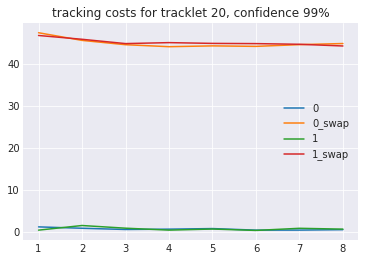

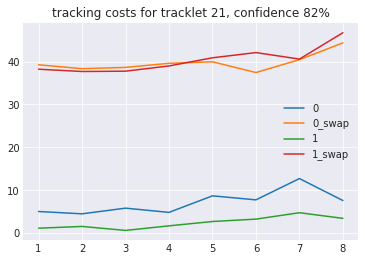

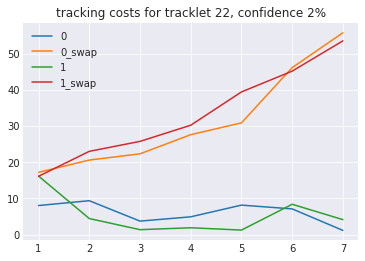

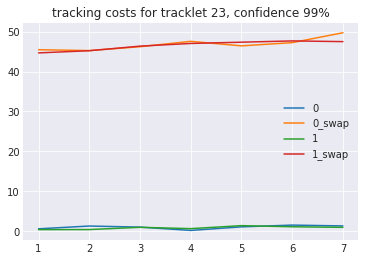

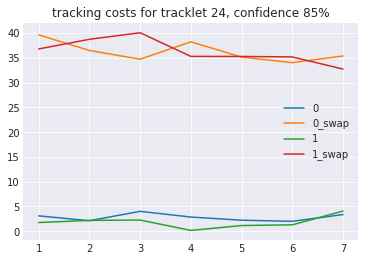

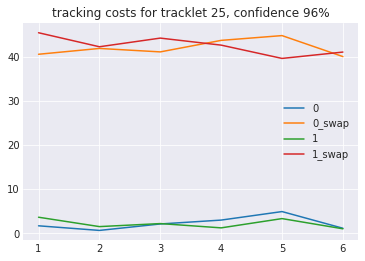

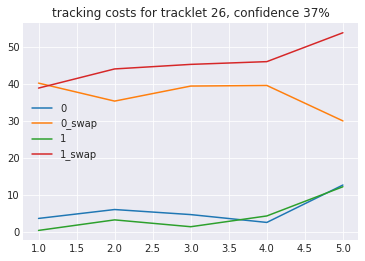

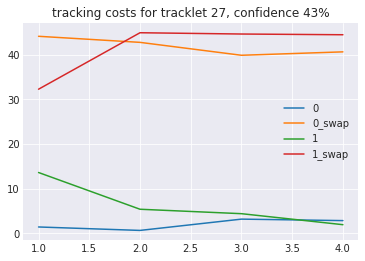

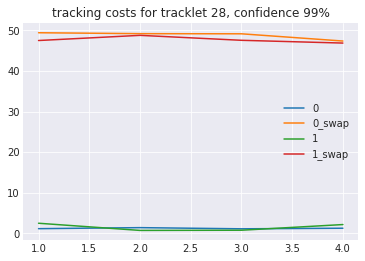

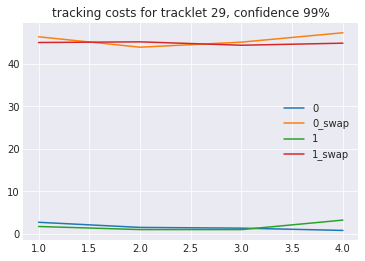

In [20]:
for i, detections in enumerate(tracklets2_detections[:30]):
    tracks, confidence, costs = detector.track(detections)
    plt.figure()
    costs.plot(title='tracking costs for tracklet {}, confidence {:,.0%}'.format(i, confidence))

In [21]:
# def strip_prefix(s):
#     return s.replace('0_', '').replace('1_', '')
   
# def object_from_series(sr, idx):
#     return sr.filter(regex='{}_'.format(idx)).rename(strip_prefix)

# Write Interaction Detection Animations

In [22]:
# write detections (no tracking)
i = 16
predictions, images = get_predictions(tracklets2[i])
detector.write_interaction_movie(images, predictions, join('out', '{:03d}.mp4'.format(i)))

HBox(children=(IntProgress(value=0, description=u'interaction detections', max=11), HTML(value=u'')))

interaction movie:   0%|          | 0/11 [00:00<?, ?it/s]

interaction movie: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]


HBox(children=(IntProgress(value=0, description=u'interaction detections', max=11), HTML(value=u'')))

interaction movie:   0%|          | 0/11 [00:00<?, ?it/s]

interaction movie: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s]


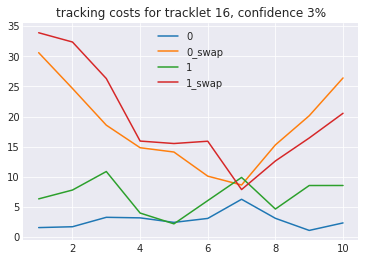

In [23]:
# write tracks
i = 16
predictions, images = get_predictions(tracklets2[i])
predictions, confidence, costs = detector.track(predictions)
predictions['0_major'] = 60
predictions['1_major'] = 60
predictions['0_minor'] = 15
predictions['1_minor'] = 15
detector.write_interaction_movie(images, predictions, join('out', '{:03d}_fixed.mp4'.format(i)))
costs.plot()
_ = plt.title('tracking costs for tracklet {}, confidence {:,.0%}'.format(i, confidence))

# Confidence

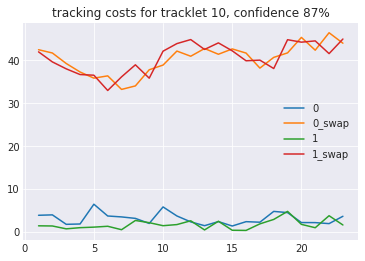

In [24]:
# try tracking
i = 10
tracks, confidence, costs = detector.track(tracklets2_detections[i])
costs.plot()
# costs['noswap'] = costs['0'] + costs['1']
# costs['swap'] = costs['0_swap'] + costs['1_swap']
# costs.loc[:, ['noswap', 'swap']].plot()
# (costs['swap'] - costs['noswap']).plot()
_ = plt.title('tracking costs for tracklet {}, confidence {:,.0%}'.format(i, confidence))

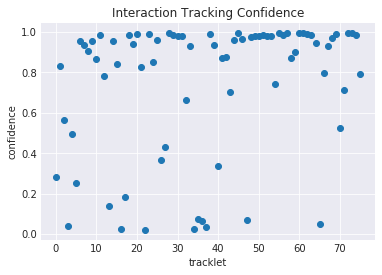

In [25]:
# interaction tracking confidence for all tracklets
confidences = [detector.track(detections)[1] for detections in tracklets2_detections]
plt.plot(confidences, 'o')
plt.ylabel('confidence')
plt.xlabel('tracklet')
_ = plt.title('Interaction Tracking Confidence')